In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
#import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
import scipy.stats as stats

from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

In [2]:
def analysis(col, tops = 10):
    temp = train[col].value_counts()
    temp = temp.iloc[:tops].index
    #temp = train.index
    temp_df = train[train[col].isin(temp)]
#     prob = temp_df[col].value_counts(normalize=True)
#     draw = np.random.choice(prob.index, p=prob, size=len(temp_df))
#     output = pd.Series(draw).value_counts(normalize=True).rename('simulated')
#     zeros = set(temp_df[col].dropna().unique()).difference(set(output.index))
#     output = output.append(pd.Series([0 for i in zeros], index = zeros)) / (temp_df[col].value_counts())
    temp_df['shuffle'] = temp_df['HasDetections'].sample(replace=False, n=len(temp_df)).reset_index(drop=True)
    output = temp_df[temp_df['shuffle'] == 1][col].value_counts() / temp_df[col].value_counts()
    pd.DataFrame({'train_data': temp_df[temp_df['HasDetections'] == 1][col].value_counts()/ temp_df[col].value_counts(),
                         'random_data': output}).plot(kind = 'bar', figsize=(20,10))
    plt.title('Percent of Has detections by {} (most of the catogaries)'.format(col))
    
    display(pd.DataFrame({'train_data': temp_df[temp_df['HasDetections'] == 1][col].value_counts()/ temp_df[col].value_counts(),
                         'random_data': output}))
    return stats.ks_2samp(temp_df[temp_df['HasDetections'] == 1][col].value_counts(normalize = True),
                output)




#stats.chi2_contingency([temp_df.groupby(col).HasDetections.mean(),
#                temp_df.groupby(col).random_data.mean()])


In [3]:
COLS = [
    'HasDetections',
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Processor'
]

In [4]:
train = pd.read_csv("train.csv", sep=',', engine='c', usecols=COLS)

In [5]:
train.head()

,Processor,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,HasDetections
0,x64,4.0,476940.0,0
1,x64,4.0,476940.0,0
2,x64,4.0,114473.0,0
3,x64,4.0,238475.0,1
4,x64,4.0,476940.0,1


In [6]:
#barplot of random_data and chi-square test statiscs over the proportion

#only takes majority of large data to proceed analyis

,train_data,random_data
1.0,0.295042,0.494843
2.0,0.459875,0.496916
3.0,0.456038,0.501915
4.0,0.507915,0.497158
6.0,0.566400,0.498798
8.0,0.555008,0.496822
12.0,0.584691,0.497994
16.0,0.561587,0.498032
24.0,0.503519,0.491608
32.0,0.498596,0.493446


Ks_2sampResult(statistic=0.9, pvalue=0.00017011925273829756)

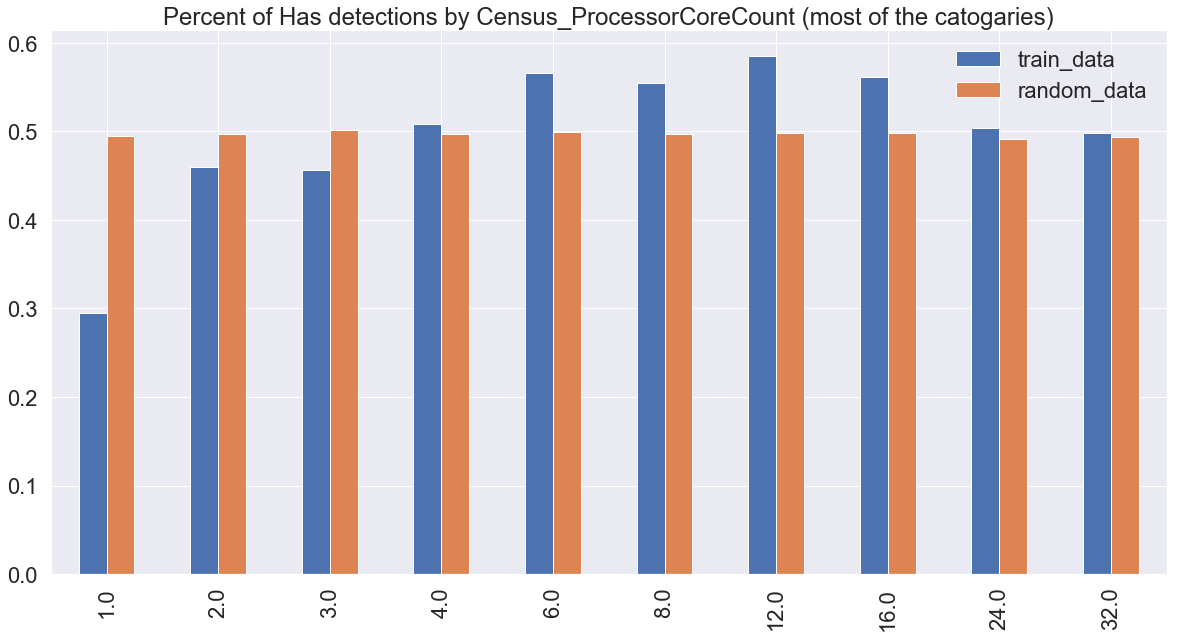

In [7]:
analysis(COLS[1])

,train_data,random_data
29820.0,0.424125,0.439374
114473.0,0.545365,0.437663
122104.0,0.527792,0.439861
228936.0,0.577324,0.440526
238475.0,0.483430,0.441772
244198.0,0.530764,0.438167
305245.0,0.440135,0.440824
476940.0,0.500258,0.440021
715404.0,0.507006,0.440239
953869.0,0.536908,0.440147


Ks_2sampResult(statistic=1.0, pvalue=1.8879793657162556e-05)

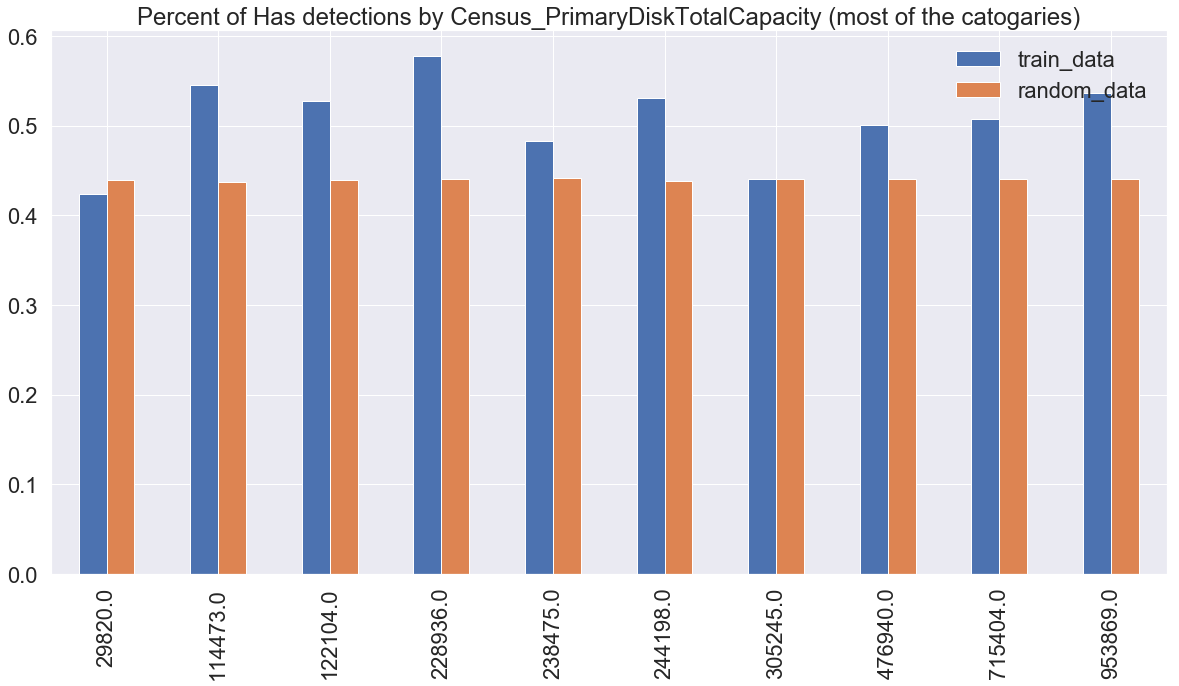

In [8]:
analysis(COLS[2])

,train_data,random_data
x64,0.511446,0.499851
x86,0.384202,0.499226
arm64,0.014451,0.471098


Ks_2sampResult(statistic=0.6666666666666666, pvalue=0.31972433327096456)

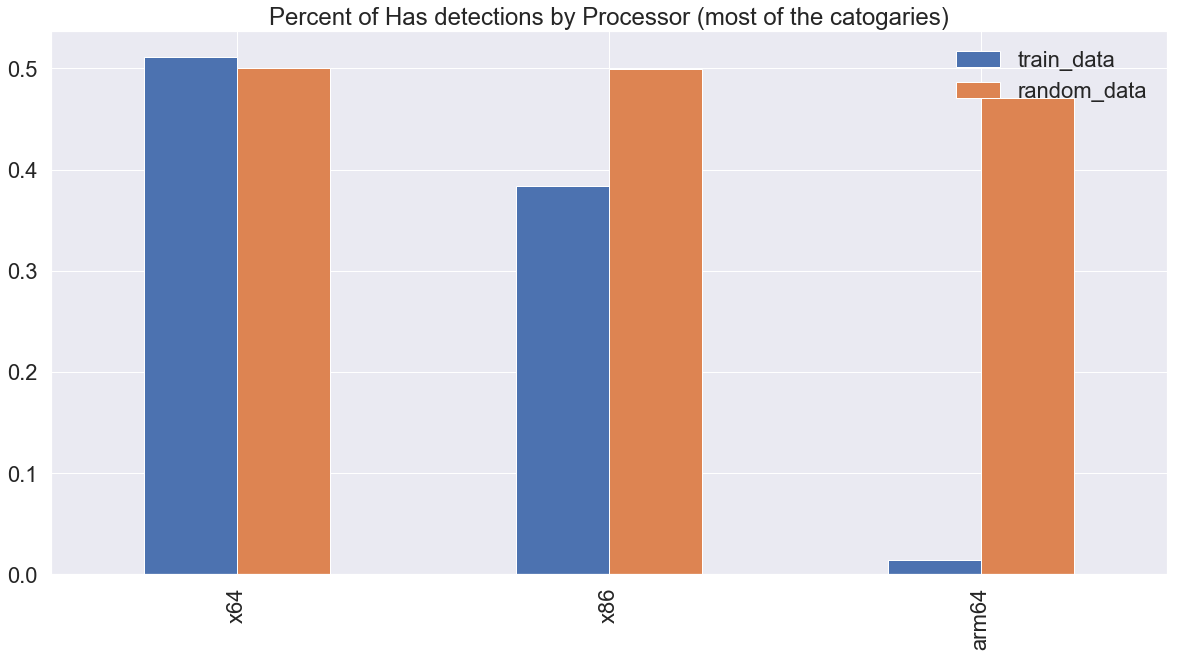

In [9]:
analysis(COLS[3])

In [10]:
#First step assumption:

#Based on plot and statistics above, we first assmue Processor > TotalDiskCapacity > Processor Core count

In [11]:
# deep study

In [12]:
def skl(col):
    nominal_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preproc = ColumnTransformer(transformers=[('onehot', nominal_transformer, col)],\
                                          remainder='drop')
    clf = RandomForestClassifier(n_estimators=7, max_depth=60)
    pl = Pipeline(steps=[('preprocessor', preproc),
                    ('clf', clf)
                    ])
    return pl

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train.dropna().drop('HasDetections',axis = 1)\
                                                    , train.dropna()['HasDetections'], test_size=0.25)
N = len(y_test)
y_random = y_test.sample(replace=False, frac = 1)

In [14]:
output = pd.DataFrame(columns = ['Observation accuracy', 'Random_Data accuracy'], index = COLS[1:])
for i in COLS[1:]:
    pl = skl([i])
    pl.fit(X_train, y_train)
    pred_score = pl.score(X_test, y_test)
    rand_score = pl.score(X_test, y_random)
    output.loc[i, 'Observation accuracy'] = pred_score
    output.loc[i, 'Random_Data accuracy'] = rand_score
pl = skl(COLS[1:])
pl.fit(X_train, y_train)
pred_score = pl.score(X_test, y_test)
rand_score = pl.score(X_test, y_random)
output.loc['combined', 'Observation accuracy'] = pred_score
output.loc['combined', 'Random_Data accuracy'] = rand_score

In [15]:
output

,Observation accuracy,Random_Data accuracy
Census_ProcessorCoreCount,0.524082,0.499893
Census_PrimaryDiskTotalCapacity,0.533193,0.499547
Processor,0.521055,0.49966
combined,0.543938,0.499912


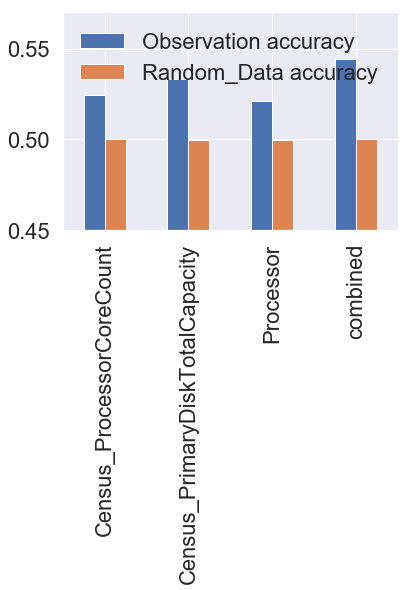

In [16]:
output.plot(kind = 'bar', ylim = (0.45, 0.57))

In [17]:
# Conclusion, hardware can influence the prediction under random forest classifer of malware
# The features combined has significant imporvement, which means it help with malware detection
# when we combines features. 